# MICQP Planning

Authors: Alan Papalia, Andrew Torgesen, Andrea Tagliabue 

## Dynamic Model

We will consider for our dynamic system a vertical takeoff and landing (VTOL) unmanned air vehicle (UAV) that is confined to the plane. Below is a diagram illustrating the system and its state variables:

![](VTOL.svg)

The equations of motion that govern the system can be expressed as

$$(m_c+m_r+m_l)\ddot{z}=-(F_l+F_r)\sin \theta$$

$$(m_c+m_r+m_l)\ddot{h}+g(m_c+m_r+m_l)=(F_l+F_r)\cos \theta$$

$$(m_l d^2+m_r d^2+J_c)\ddot{\theta}+(m_r-m_l)gd\cos \theta=(F_r-F_l)d$$

where $z$ is the horizontal coordinate of the VTOL, $\theta$ is the clockwise deviation of the right rotor from the horizontal, $h$ is the VTOL altitude, $F_l$ and $F_r$ are the left and right rotor thrusts, and with the parameter definitions:

| Variable | Explanation            | Value        |
|----------|------------------------|--------------|
| $m_c$      | Mass of VTOL body      | 1 $kg$         |
| $m_l$      | Mass of left rotor     | 0.25 $kg$      |
| $m_r$      | Mass of right rotor    | 0.25 $kg$      |
| $J_c$      | VTOL Moment of inertia | 0.0042 $kg~m^2$ |
| $d$        | Rotor arm length       | 0.3 $m$        |
| $\mu$      | Air drag term          | 0.1 $kg/s$     |
| $g$        | Gravity                | 9.81 $m/s^2$   |

For the purpose of trajectory generation, we provide a simplified model of the system, founded on the following assumptions:

  - The longitudinal and lateral dynamics of the VTOL can be considered as decoupled (separate) systems
  - The dynamics can be considered as linear within a finite state space region surrounding the "equilibrium" flight regime, which is characterized by steady, level flight.
  
With the above assumptions, here is the simplified state-space model of the VTOL:

$$\dot{x}_{lon}=\begin{bmatrix}0 & 1 \\ 0 & 0\end{bmatrix}x_{lon}+\begin{bmatrix}0\\\frac{1}{m_l+m_r+m_c}\end{bmatrix}u_{lon}$$

$$y_{lon}=\begin{bmatrix}1 & 0\end{bmatrix}x_{lon}$$

$$\dot{x}_{lat}=\begin{bmatrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\0 & -g & \frac{-\mu}{m_c+m_l+m_r} & 0\\0 & 0 & 0 & 0\end{bmatrix}x_{lat}+\begin{bmatrix}0\\0\\0\\\frac{1}{m_ld^2+m_rd^2+J_c}\end{bmatrix}u_{lat}$$

$$y_{lat}=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}x_{lat}$$

where $x_{lon}=\begin{bmatrix}h&\dot{h}\end{bmatrix}^T$,  $x_{lat}=\begin{bmatrix}z&\theta&\dot{z}&\dot{\theta}\end{bmatrix}^T$, $u_{lon}\triangleq F =f_r+f_l$, and $u_{lat}\triangleq \tau=d(f_r-f_l)$.

In [2]:
import vtolParam as P
from vtolAnimation import vtolAnimation
from vtolDynamics import vtolDynamics
from IPython.display import HTML
from math import sin, pi
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

<IPython.core.display.Javascript object>


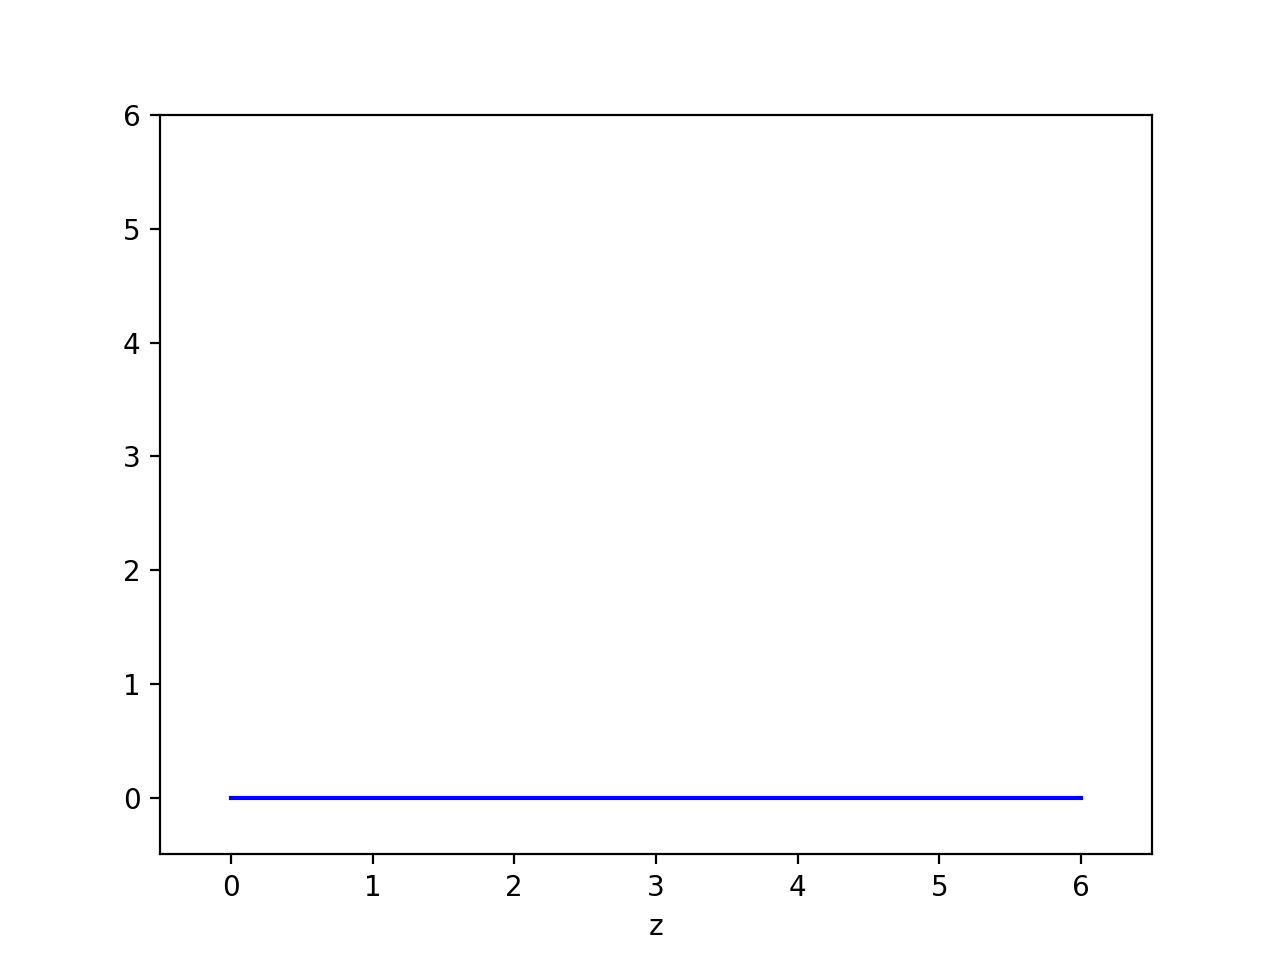

In [3]:
n = int((P.tf-P.t0)/P.Ts)
int((P.tf-P.t0)/P.Ts)
def getTime(i):
    return P.t0 + i * P.Ts

# Get inputs to system (will come from optimization)
inputs = list()
for i in range(0, n):
    t = getTime(i)
    F = P.Fe
    T = 0.0
    if t < 5:
        F += 0.1
    else:
        T += 0.1
    inputs.append([F, T])

# Simulation + Animation
vtol = None
animation = vtolAnimation()
def animate(i):
    global vtol
    if i == 0:
        vtol = vtolDynamics()
    vtol.propagateDynamics(inputs[i])
    animation.drawVtol(vtol.outputs())
ani = matplotlib.animation.FuncAnimation(animation.fig, animate, n, interval=1000*P.Ts)

## Introduction to Trajectory Optimization
The objective of trajectory optimization is to generate a time-parametrized path (a trajectory) which minimized a given performance metric, while satisfying a set of constraints. This problem is closely  related to solving an optimal control, open-loop problem. 

In roboti applications, the planned trajectory is usually fed  as input to the motion control architecture of the robot, and has to satisfy strict requirements in terms of dynamic feasibility, smoothness, ability to be re-computed efficienty... 

Example of performance metric commonly found in robotics are:
- the energy required to follow the trajectory
- the control effort (often related to energy) required
- the average or maximum acceleration/jerk/snap 
- the time to execute the trakjectory.

Exampled of constraints typically found in robotics are:
- constraints from the environment,  such as obstacles, static or dynamic, that must be avoided
- constraints on the performance of the system, such as the maximum control effort, or saturations on the actuators of the robot
- the final time and final state of the robot (e.g. think of trying to intercept a moving object)
- kinematic and dynamic constraints (e.g. a car cannot move sideways or a quadcopter cannot accelerate horizonatally without pitching or rolling).

Trajectory optimization is usually considered as a local planning problem, since we are only interested in generating a trajectory which terminates a few meters away from the current position of the robot (but the termination point is constantly updated as the robot moves). In addition, trajectory optimizatio assumes that a desired initial state and final goal state are given (for example by a global planner/mission planner).

#### Mathematical formulation
The Trajectory optimizatio problem can be mathematically formulated as follows:
$$\min_{p} J(p)$$ $$ \text{s.t.} \\ p \in P$$

where $J()$ is the objective function, $p$ represents all the possible input and state trajectories, and $P$ is the set of state trajectory satisfying given constraints. 

#### Techniques used to solve the trejectory optimization problem
The typical techniques used to solve a trajectory optimization can be grouped in two cathegories:
- direct method: iteratively construct a numerical approximation to the solution to the problem. 
- indirect method: analytically constructs the direct and sufficent conditions for optimality, which are then solved numerically.

Source: https://en.wikipedia.org/wiki/Trajectory_optimization

## Review on Convex Optimization, QP, QCQP,  LP, MILP, MIQCP
##### Convex Optimization
A convex optimization problem is an optimization problem in which the objective function is a convex function and the feasible set is a convex set. It can be formulated in the form:
$$\displaystyle \min_{x} f(x)$$
$$\text{subject to} \\ g_i(x) \leq 0, \ i=1, ..., m$$
$$\\ h_i(x) \leq 0, \ i=1, ..., p$$
where $f, g_1, ..., g_m$ are convex and $h_1, ..., h_p$ are affine. 

Under these assumption, the problem has the followint properties:
- every local minimum is a global minimum
- the optimal set is convex
- if the objective function  is strictly convex, then the problem has at most one optimal point.

##### Linear Programming
In linear programming, an optimization problem is characterized by:
- a linear cost function
- a linear set of inequality constraints
- non negative variables

It can thus be formulated in mathematical form as:
$$\displaystyle \max_{x} c^Tx$$
$$ \text{subject to} \\ Ax\leq b \\x \geq 0 $$ 
 
Geometrically, the inequlity constraints, which define the feasible region, describe a convex polyhedron. The linear objective function is a convex function, which implies that every local minimum is a global minimum. A LP/MILP is then a convex optimization problem.
A solution is guaranteed to exist under the assumptions that the problem is feasible (the feasible space described by the constraints is non-zero) and that the problem is not unbounded.

##### Mixed Integer Linear Programming
A linear problem is said to be integral if it has at least one optimal solution which is integral. This means that the domain of some of the optimixation variables $x$ is defined on $Z$. 

##### (Quadratically Constrained) Quadratic Programming
A quadratic program is an optimization problem where the cost function is quadratic. The cost function has the form:
$$f(x)=\frac{1}{2}x^TQx + c^Tx$$

If the constraints are expressed in quadratic form, then the problem is said to be Quadratically Constrained. In a QCQP, the constraints can be expressed as:
        $$g_i(x) = \frac{1}{2}x^TP_ix + q_i^Tx + r_i \leq 0 \\ \text{for} \ i = 1, ..., m$$
Linear or affine constraints can also be included (e.g $Ax = b$)

#### Mixed Integer Quadratically Constrained Programming
If a proble has any constraints containing a quadratic term, regardless of the objective function, the problem is termed a Mixed Integer Quadratically Constrained Program (MIQCP). Since the problem is also a Mixed-Integer, then the domain of some of the optimization variables is defined oin $Z$.

Sources: https://en.wikipedia.org/wiki/Linear_programming, https://en.wikipedia.org/wiki/Convex_optimization, https://en.wikipedia.org/wiki/Quadratically_constrained_quadratic_program, https://support.sas.com/rnd/app/or/procedures/milp.html

## Trajectory Optimization problem Formulation for a VTOL
The trajectory optimization problem for our VToL which has to navigatve trough obstacles can be formulated in the way described in the following paragraphs. We will assume that a final time is fixed. As an alternative, we could have solved the problem in a receding horizon fashion (TODO: Andrea: detail more if we implement this method).  Due to the presence of constraints (such as on the velocity) which involve both the lateral and longitudinal dynamics, the optimization problem cannot be decoupled.
##### Continuous time objective function
We use a minimum control effort criteria (which is related to minimizing the energy used by the VTOL, since the square of the thrust force produced by the propellers is roughly proportional to the instant power consumption)

$$\displaystyle \min_{x(t) \ u(t)} J(x(t), u(t), t)$$

where: $$J(x(t), u(t), t) = \int_{t_0}^{t_0 + T} u(t)^2 dt$$ 

with 

$$x(t) = [x^T_\text{lat}(t), x^T_\text{lon}(t)]^T \in R^6$$ 
$$u(t) = [u^T_\text{lat}(t), u^T_\text{lon}(t)]^T \in R^2$$

and the scalar $t_0 \in R$ is and arbitrary initial time and  $T \in R$ is the fixed total time to execute the trajectory.

##### Constraints
Notation declaration: for conveninency, we drop the time-dependency notation as it can be deduced without ambiguity from the context. 
The set of constraints considered are the following:
- System dynamics (not-linearized)
$$ \dot{x(t)} = f(x(t), u(t), t) $$
- Avoiding static obstacles:
Given a set of obstacles TODO
- Maximum velocity
$$ ||[\dot{h}, \dot{z}]^T||_{l_2} \leq \bar{v}$$
where $\bar{v}$ is a maximum given velocity.
- Fixed arrival time, initial and final position
$$x(0) = x_0$$
$$u(0) = u_0$$
$$x(T) = x_T$$
$$u(T) = u_T$$
$$T = \bar{T}$$
- Saturation on the actuators 
$$u(t) \geq \bar{u}$$